In [13]:
import requests
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from datetime import datetime, timedelta
import os

nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

API_KEY = 'f436f3063b6a49ddb099ab1ded54b6a0'

companies = {
    'ypf': 'YPF',
    'pampa_energía': 'PAM',
    'ecopetrol': 'EC',
    'petrobras': 'PBR',
    'interconexion_electrica': 'ISA',
    'minas_buenaventura': 'BVN',
    'eletrobras': 'EBR',
    'engie_brasil_energia': 'EGIE3',
    'vista_energy': 'VIST',
    'aes_andes': 'AES'
}

def get_news(company_name, days=30, max_results=100):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    query = f'"{company_name}" OR "{companies[company_name]}"'
    
    url = f'https://newsapi.org/v2/everything?q={query}&from={start_date.date()}&to={end_date.date()}&sortBy=publishedAt&language=en&pageSize={max_results}&apiKey={API_KEY}'
    
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error al obtener noticias para {company_name}. Código de estado: {response.status_code}")
        print(f"Respuesta: {response.json()}")
        return []
    
    data = response.json()
    articles = data.get('articles', [])
    
    if not articles:
        print(f"No se encontraron noticias para {company_name}. URL de búsqueda: {url}")
    else:
        print(f"Se encontraron {len(articles)} noticias para {company_name}")
    
    return articles

def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

def analyze_company_sentiment(company_name, ticker):
    news = get_news(company_name)
    sentiment_data = []
    
    for article in news:
        title = article.get('title', '')
        description = article.get('description', '')
        content = article.get('content', '')
        date = article.get('publishedAt', '')[:10]
        
        full_text = f"{title} {description} {content}"
        sentiment = analyze_sentiment(full_text)
        
        # Solo incluir noticias con sentimiento negativo
        if sentiment < 0:
            sentiment_data.append({
                'Date': date,
                'Company': company_name,
                'Ticker': ticker,
                'Sentiment': sentiment,
                'Title': title
            })
    
    return pd.DataFrame(sentiment_data)

def main():
    all_sentiment_data = pd.DataFrame()

    for company_name, ticker in companies.items():
        company_sentiment = analyze_company_sentiment(company_name, ticker)
        if not company_sentiment.empty:
            all_sentiment_data = pd.concat([all_sentiment_data, company_sentiment], ignore_index=True)
            print(f"Análisis completado para {company_name}. Noticias negativas encontradas: {len(company_sentiment)}")
        else:
            print(f"No se encontraron noticias negativas para {company_name}")

    if all_sentiment_data.empty:
        print("No se encontraron noticias negativas para ninguna empresa.")
    else:
        all_sentiment_data['Date'] = pd.to_datetime(all_sentiment_data['Date'])
        all_sentiment_data = all_sentiment_data.sort_values('Date')

        daily_sentiment = all_sentiment_data.groupby(['Date', 'Company', 'Ticker']).agg({
            'Sentiment': ['mean', 'min', 'max', 'count'],
            'Title': lambda x: x.iloc[0]  # Toma el primer título del día
        }).reset_index()

        daily_sentiment.columns = ['Date', 'Company', 'Ticker', 'Avg_Sentiment', 'Min_Sentiment', 'Max_Sentiment', 'News_Count', 'Sample_Title']

        if not os.path.exists('datasets2/'):
            os.makedirs('datasets2/')

        all_sentiment_data.to_csv('datasets2/all_negative_news_sentiment.csv', index=False)
        daily_sentiment.to_csv('datasets2/daily_negative_sentiment_summary.csv', index=False)

        print("Análisis de sentimiento negativo completado. Los resultados se han guardado en 'datasets2/all_negative_news_sentiment.csv' y 'datasets2/daily_negative_sentiment_summary.csv'")
        print(f"Total de noticias negativas analizadas: {len(all_sentiment_data)}")

if __name__ == "__main__":
    main()

Se encontraron 29 noticias para ypf
Análisis completado para ypf. Noticias negativas encontradas: 3
Se encontraron 100 noticias para pampa_energía
Análisis completado para pampa_energía. Noticias negativas encontradas: 23
Se encontraron 100 noticias para ecopetrol
Análisis completado para ecopetrol. Noticias negativas encontradas: 20
Se encontraron 100 noticias para petrobras
Análisis completado para petrobras. Noticias negativas encontradas: 8
Se encontraron 100 noticias para interconexion_electrica
Análisis completado para interconexion_electrica. Noticias negativas encontradas: 47
Se encontraron 20 noticias para minas_buenaventura
Análisis completado para minas_buenaventura. Noticias negativas encontradas: 3
Se encontraron 12 noticias para eletrobras
No se encontraron noticias negativas para eletrobras
No se encontraron noticias para engie_brasil_energia. URL de búsqueda: https://newsapi.org/v2/everything?q="engie_brasil_energia" OR "EGIE3"&from=2024-08-07&to=2024-09-06&sortBy=publi

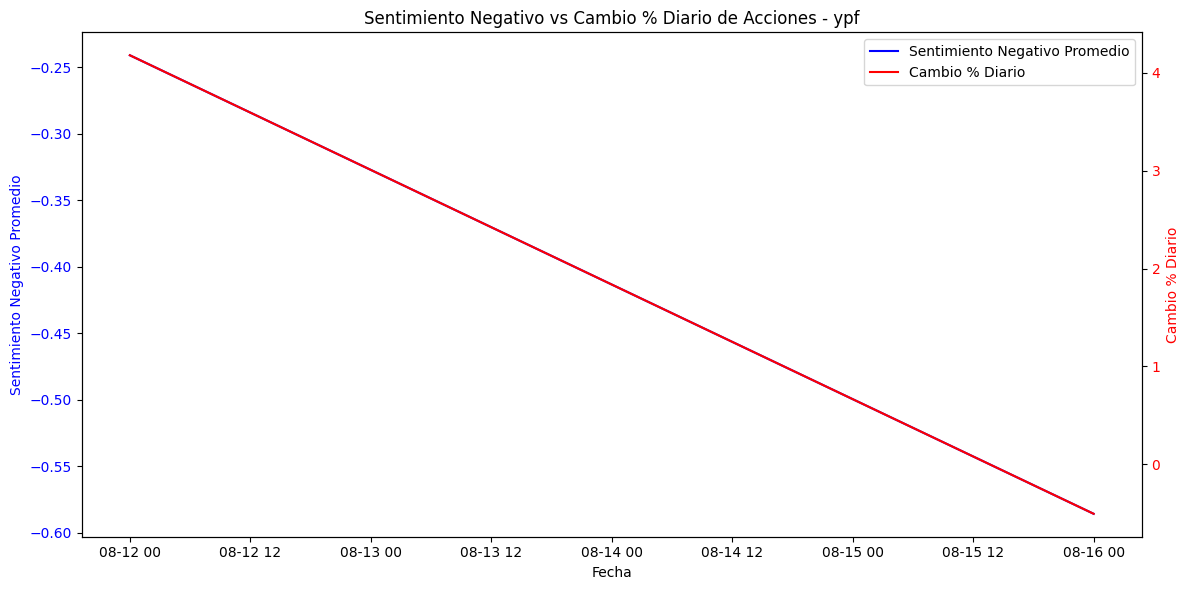

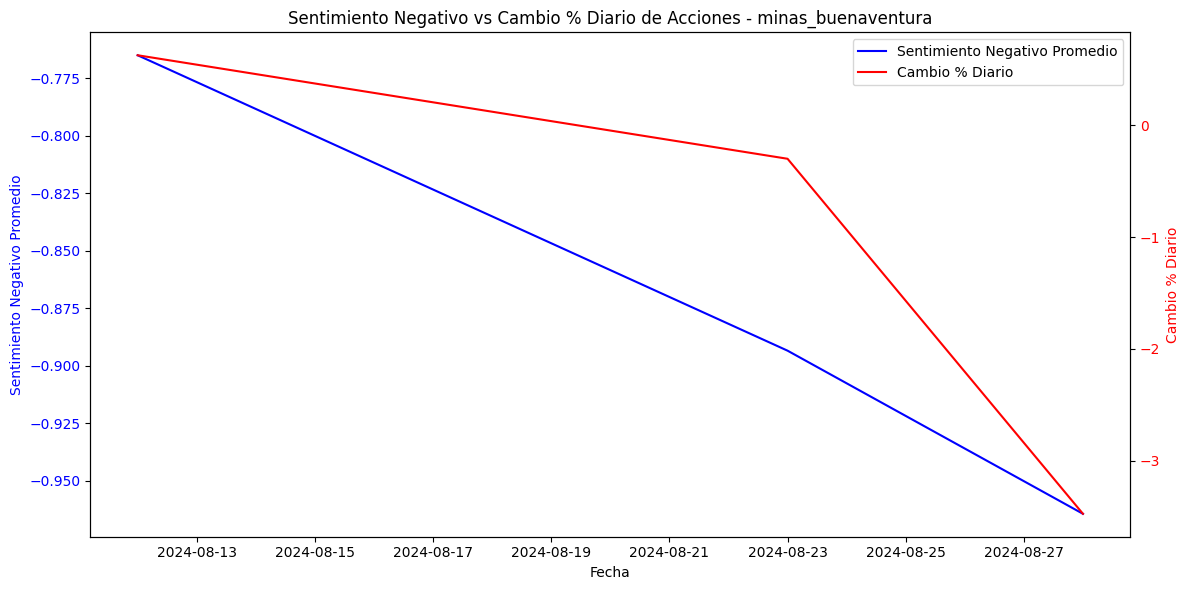

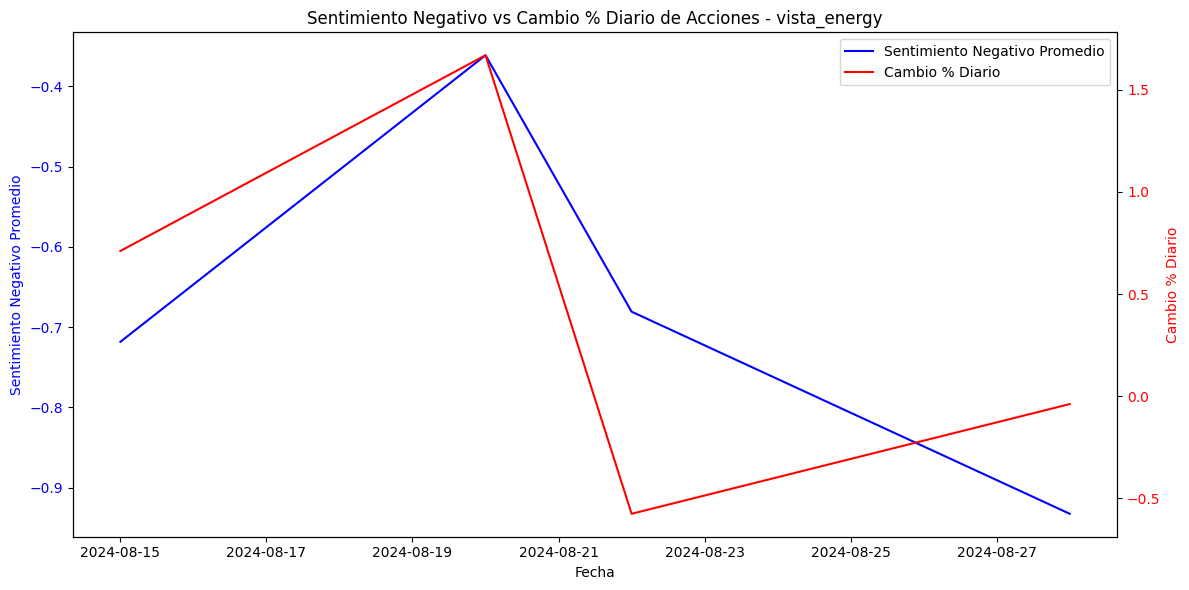

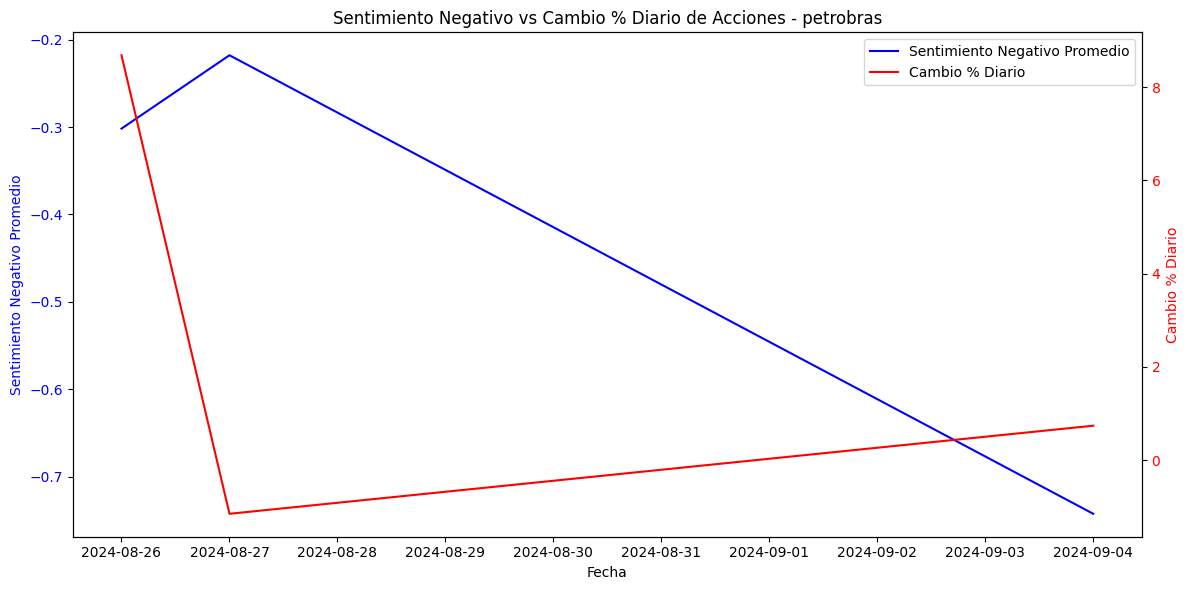

No hay datos coincidentes para aes_andes


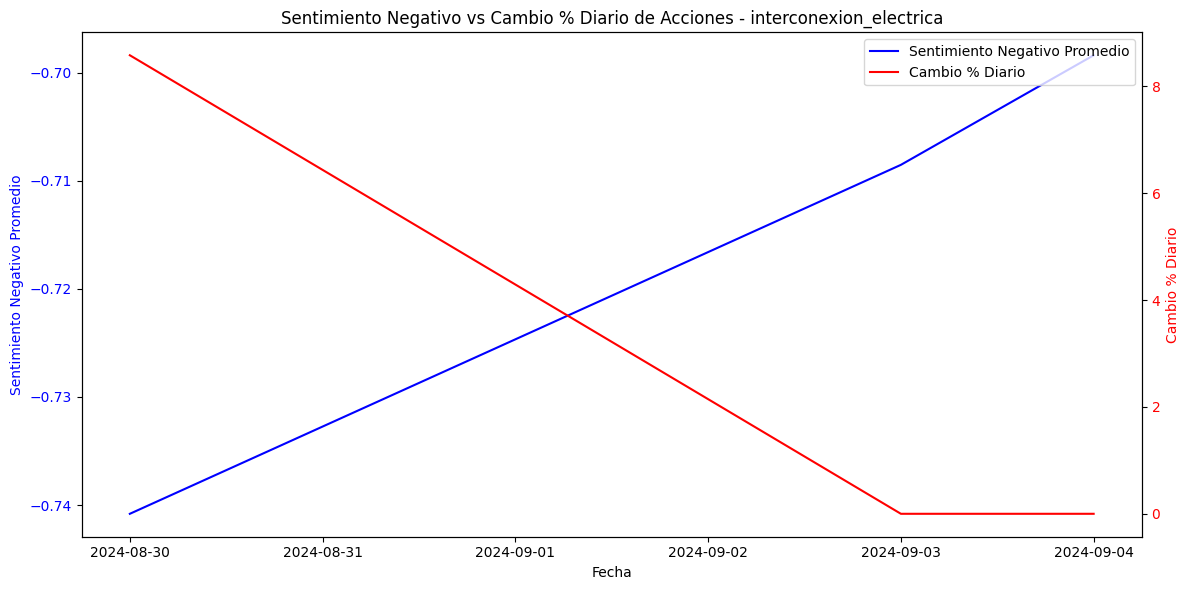

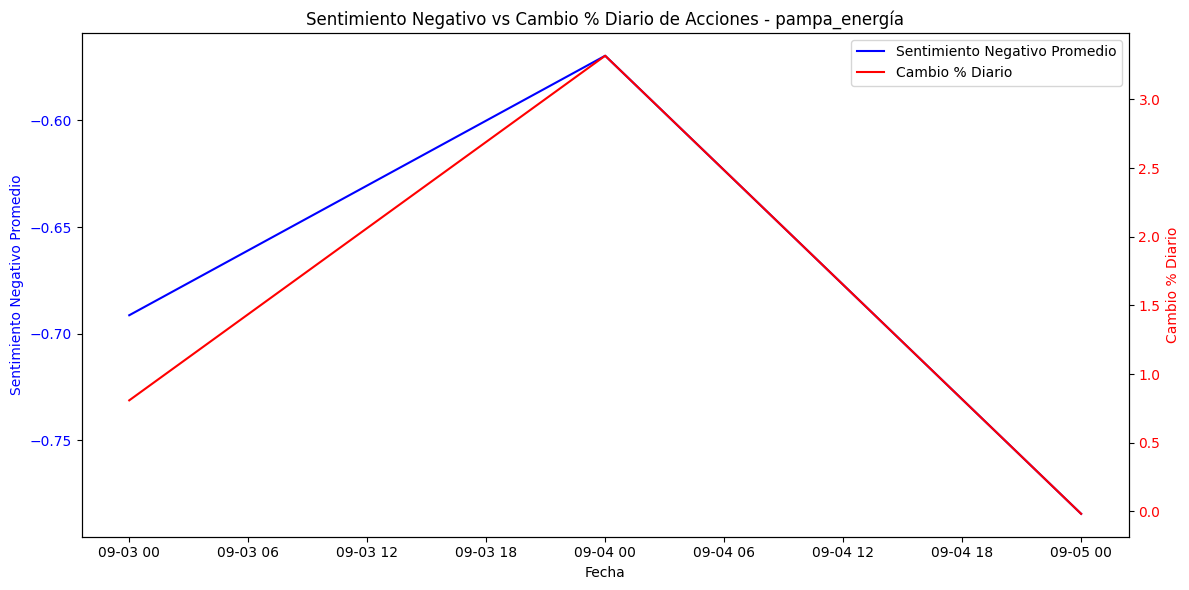

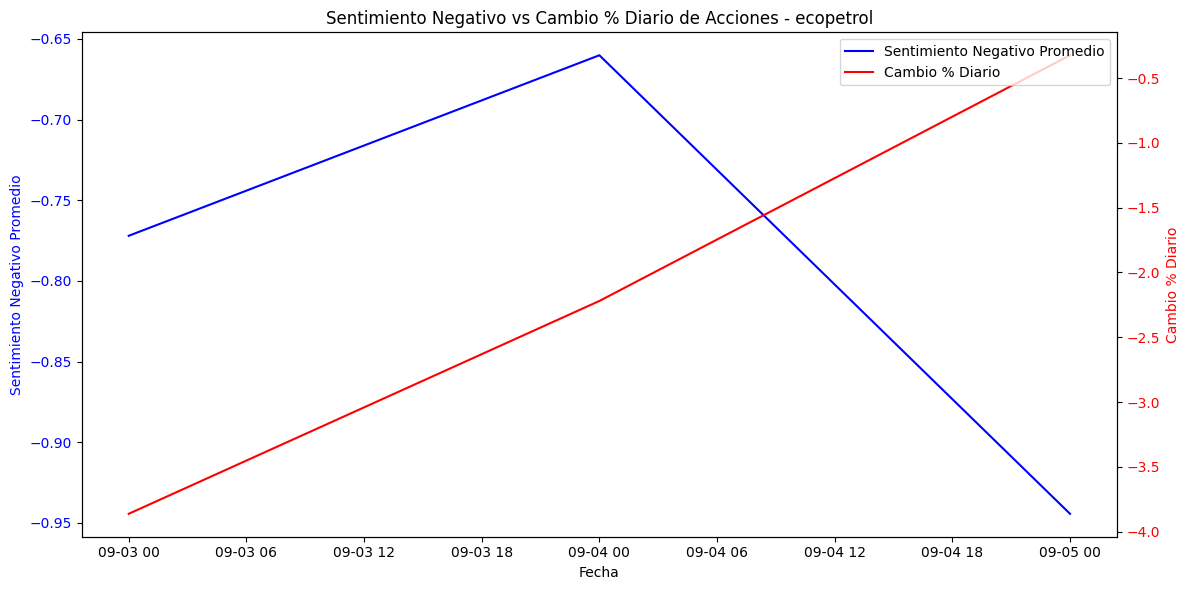

No hay datos coincidentes para calcular la correlación de aes_andes
Correlaciones entre Sentimiento Negativo y Cambio % Diario de Acciones:
                   Company  Correlation
0                      ypf     1.000000
5            pampa_energía     0.978688
1       minas_buenaventura     0.890775
2             vista_energy     0.730424
3                petrobras     0.190938
6                ecopetrol    -0.634313
4  interconexion_electrica    -0.973467
Las correlaciones se han guardado en 'datasets2/negative_sentiment_stock_correlations.csv'


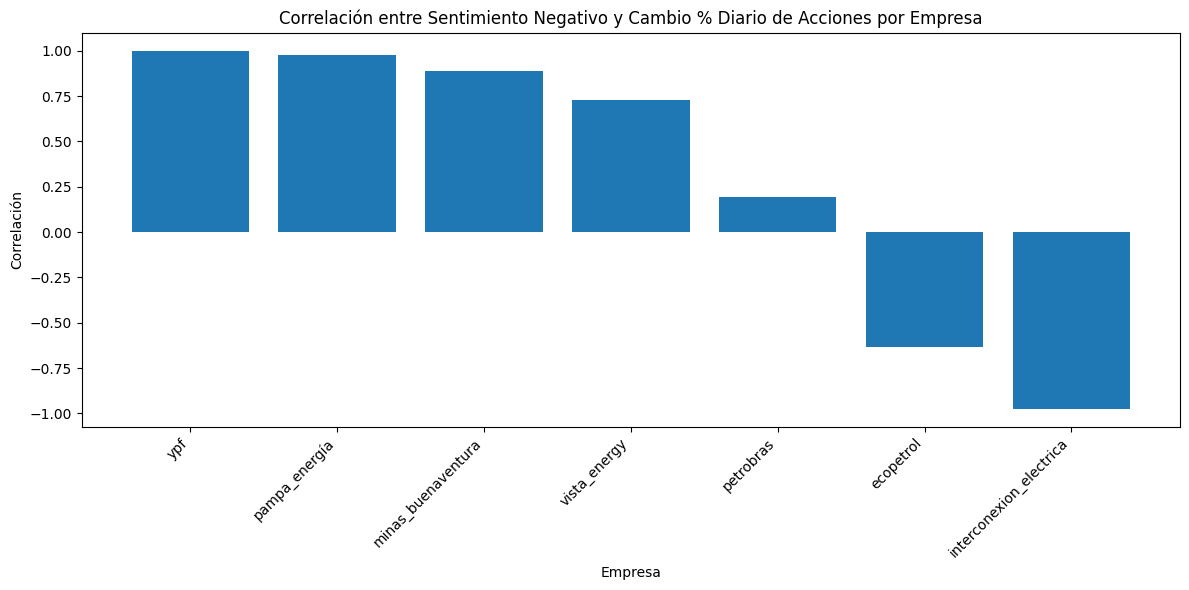

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

# Ignorar el warning 
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Cargar los datos
sentiment_data = pd.read_csv('datasets2/daily_negative_sentiment_summary.csv')
stock_data = pd.read_csv('datasets2/all_companies_stock_data.csv')

# Convertir las fechas a datetime
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date']).dt.strftime('%Y-%m-%d')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.strftime('%Y-%m-%d')

# Datos ordenados por fecha
sentiment_data = sentiment_data.sort_values('Date')
stock_data = stock_data.sort_values('Date')

# Función para calcular el cambio porcentual diario
def calculate_daily_change(group):
    group['Daily_Change'] = group['Close'].pct_change() * 100
    return group

# Calcular el cambio porcentual diario para cada empresa
stock_data = stock_data.groupby('Company', group_keys=False).apply(calculate_daily_change)

# Función para graficar la comparación para una empresa
def plot_sentiment_vs_stock(company):
    company_sentiment = sentiment_data[sentiment_data['Company'] == company]
    company_stock = stock_data[stock_data['Company'] == company]
    
    # Combinar los datos de sentimiento y acciones
    merged_data = pd.merge(company_sentiment, company_stock, on=['Date', 'Company'], how='inner')
    
    if merged_data.empty:
        print(f"No hay datos coincidentes para {company}")
        return
    
    # Convertir la fecha de nuevo a datetime para la gráfica
    merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    
    # Crear la gráfica
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Graficar el sentimiento negativo
    ax1.plot(merged_data['Date'], merged_data['Avg_Sentiment'], color='blue', label='Sentimiento Negativo Promedio')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Sentimiento Negativo Promedio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Crear un segundo eje y para el cambio porcentual de las acciones
    ax2 = ax1.twinx()
    ax2.plot(merged_data['Date'], merged_data['Daily_Change'], color='red', label='Cambio % Diario')
    ax2.set_ylabel('Cambio % Diario', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Añadir título y leyenda
    plt.title(f'Sentimiento Negativo vs Cambio % Diario de Acciones - {company}')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    
    # Ajustar el diseño
    plt.tight_layout()
    
    # Guardar la gráfica
    plt.savefig(f'datasets2/{company}_negative_sentiment_vs_stock.png')
    
    # Mostrar la gráfica
    plt.show()

# Graficar para cada empresa
for company in sentiment_data['Company'].unique():
    plot_sentiment_vs_stock(company)

# Calcular la correlación entre sentimiento negativo y cambio de acciones para cada empresa
correlations = []
for company in sentiment_data['Company'].unique():
    company_sentiment = sentiment_data[sentiment_data['Company'] == company]
    company_stock = stock_data[stock_data['Company'] == company]
    
    merged_data = pd.merge(company_sentiment, company_stock, on=['Date', 'Company'], how='inner')
    
    if not merged_data.empty:
        correlation = merged_data['Avg_Sentiment'].corr(merged_data['Daily_Change'])
        correlations.append({'Company': company, 'Correlation': correlation})
    else:
        print(f"No hay datos coincidentes para calcular la correlación de {company}")

correlation_df = pd.DataFrame(correlations)
correlation_df = correlation_df.sort_values('Correlation', ascending=False)

print("Correlaciones entre Sentimiento Negativo y Cambio % Diario de Acciones:")
print(correlation_df)

# Guardar las correlaciones en un archivo CSV
correlation_df.to_csv('datasets2/negative_sentiment_stock_correlations.csv', index=False)
print("Las correlaciones se han guardado en 'datasets2/negative_sentiment_stock_correlations.csv'")

# Crear un gráfico de barras para las correlaciones
plt.figure(figsize=(12, 6))
plt.bar(correlation_df['Company'], correlation_df['Correlation'])
plt.title('Correlación entre Sentimiento Negativo y Cambio % Diario de Acciones por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Correlación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('datasets2/negative_correlations_bar_chart.png')
plt.show()